In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


# IMPORT THE REQUIREMENTS LIBRARIES

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical


In [ ]:
from tensorflow.keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split


# Load the Fashion MNIST data
(x_train_full, y_train_full), (x_test, y_test) = fashion_mnist.load_data()

train_size = 0.2
x_train, x_unused, y_train, y_unused = train_test_split(
    x_train_full,
    y_train_full,
    train_size=train_size,
    random_state=42  # for reproducible results
)

# Check the size of the data
print("Training data shape:", x_train.shape)
print("Training labels shape:", y_train.shape)
print("Test data shape:", x_test.shape)
print("Test labels shape:", y_test.shape)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training data shape: (12000, 28, 28)
Training labels shape: (12000,)
Test data shape: (10000, 28, 28)
Test labels shape: (10000,)


Samples from the Dataset

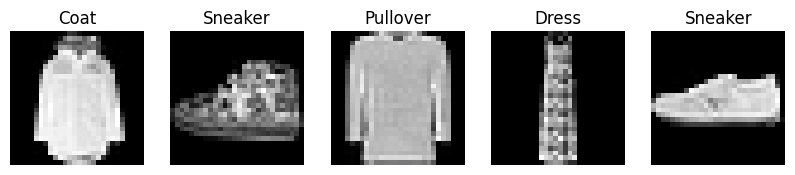

In [ ]:
import matplotlib.pyplot as plt

# Fashion MNIST classes
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Display the first 5 images
plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_train[i], cmap='gray')  # Fashion MNIST is grayscale
    plt.title(class_names[y_train[i]])
    plt.axis('off')
plt.show()


In [ ]:
X_train = x_train.reshape(-1, 28*28).astype('float32') / 255.0
X_test = x_test.reshape(-1, 28*28).astype('float32') / 255.0

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [ ]:
X_train.shape

(12000, 784)

In [ ]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [ ]:
y_train.shape

(12000, 10)

# Model Architecture

###Initialize Network Parameters

In [ ]:

# Initialize weights
def init_params():
    input_size = 28*28 #784
    hidden1 = 1024
    hidden2 = 512
    hidden3 = 256
    output_size = 10

    # Xavier initialization

    W1 = np.random.randn(input_size, hidden1) * np.sqrt(2. / input_size)
    b1 = np.zeros((1, hidden1))

    W2 = np.random.randn(hidden1, hidden2) * np.sqrt(2. / hidden1)
    b2 = np.zeros((1, hidden2))

    W3 = np.random.randn(hidden2, hidden3) * np.sqrt(2. / hidden2)
    b3 = np.zeros((1, hidden3))

    W4 = np.random.randn(hidden3, output_size) * np.sqrt(2. / hidden3)
    b4 = np.zeros((1, output_size))

    return W1, b1, W2, b2, W3, b3, W4, b4



In [ ]:
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def softmax(x):
    exps = np.exp(x - np.max(x, axis=1, keepdims=True))  # stability
    return exps / np.sum(exps, axis=1, keepdims=True)


In [ ]:
# --- Dropout ---
def apply_dropout(A, dropout_rate):
    mask = (np.random.rand(*A.shape) > dropout_rate).astype(float)
    return A * mask / (1.0 - dropout_rate), mask  # scale to keep expected value the same

In [ ]:
def cross_entropy(y_true, y_pred):
    eps = 1e-8
    return -np.mean(np.sum(y_true * np.log(y_pred + eps), axis=1))


In [ ]:
# def forward(X):
#     z1 = np.dot(X, W1) + b1
#     a1 = relu(z1)

#     z2 = np.dot(a1, W2) + b2
#     a2 = relu(z2)

#     z3 = np.dot(a2, W3) + b3
#     a3 = softmax(z3)

#     return z1, a1, z2, a2, z3, a3

In [ ]:
def forward(X, training=True, dropout_rate=0.3):
    z1 = np.dot(X, W1) + b1
    a1 = relu(z1)

    if training:
        a1, mask1 = apply_dropout(a1, dropout_rate)
    else:
        mask1 = None

    z2 = np.dot(a1, W2) + b2
    a2 = relu(z2)

    if training:
        a2, mask2 = apply_dropout(a2, dropout_rate)
    else:
        mask2 = None

    z3 = np.dot(a2, W3) + b3
    a3 = relu(z3)

    if training:
        a3, mask3 = apply_dropout(a3, dropout_rate)
    else:
        mask3 = None

    z4 = np.dot(a3, W4) + b4
    a4 = softmax(z4)

    return z1, a1, mask1, z2, a2, mask2, z3, a3, mask3, z4, a4


In [ ]:
# def backward(X, y_true, z1, a1, z2, a2, learning_rate=0.01):
#     global W1, b1, W2, b2
#     m = y_true.shape[0]


#     dz2 = a2 - y_true
#     dW2 = np.dot(a1.T, dz2) / m
#     db2 = np.sum(dz2, axis=0, keepdims=True) / m

#     da1 = np.dot(dz2, W2.T)
#     dz1 = da1 * relu_derivative(z1)
#     dW1 = np.dot(X.T, dz1) / m
#     db1 = np.sum(dz1, axis=0, keepdims=True) / m


#     W1 -= learning_rate * dW1
#     b1 -= learning_rate * db1
#     W2 -= learning_rate * dW2
#     b2 -= learning_rate * db2

In [ ]:
def backward(X, y_true, z1, a1, mask1, z2, a2, mask2, z3, a3, mask3, z4, a4, learning_rate=0.01, dropout_rate=0.3):
    m = y_true.shape[0]
    global W1, b1, W2, b2, W3, b3, W4, b4

    dz4 = a4 - y_true
    dW4 = np.dot(a3.T, dz4) / m
    db4 = np.sum(dz4, axis=0, keepdims=True) / m

    da3 = np.dot(dz4, W4.T)
    if mask3 is not None:
        da3 *= mask3 * (1.0 - dropout_rate)
    dz3 = da3 * relu_derivative(z3)
    dW3 = np.dot(a2.T, dz3) / m
    db3 = np.sum(dz3, axis=0, keepdims=True) / m

    da2 = np.dot(dz3, W3.T)
    if mask2 is not None:
        da2 *= mask2 * (1.0 - dropout_rate)
    dz2 = da2 * relu_derivative(z2)
    dW2 = np.dot(a1.T, dz2) / m
    db2 = np.sum(dz2, axis=0, keepdims=True) / m

    da1 = np.dot(dz2, W2.T)
    if mask1 is not None:
        da1 *= mask1 * (1.0 - dropout_rate)
    dz1 = da1 * relu_derivative(z1)
    dW1 = np.dot(X.T, dz1) / m
    db1 = np.sum(dz1, axis=0, keepdims=True) / m

    W4 -= learning_rate * dW4
    b4 -= learning_rate * db4
    W3 -= learning_rate * dW3
    b3 -= learning_rate * db3
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1

Without Dropout Training

In [ ]:
# def train(X, y, epochs=10, batch_size=64, learning_rate=0.01):
#     for epoch in range(epochs):
#         permutation = np.random.permutation(X.shape[0])
#         X_shuffled = X[permutation]
#         y_shuffled = y[permutation]

#         for i in range(0, X.shape[0], batch_size):
#             X_batch = X_shuffled[i:i+batch_size]
#             y_batch = y_shuffled[i:i+batch_size]

#             z1, a1, z2, a2 = forward(X_batch)
#             backward(X_batch, y_batch, z1, a1, z2, a2, learning_rate)

#         # Evaluate
#         _, _, _, preds = forward(X)
#         loss = cross_entropy(y, preds)
#         acc = np.mean(np.argmax(preds, axis=1) == np.argmax(y, axis=1))
#         print(f"Epoch {epoch+1}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")

In [ ]:
def train(X, y, epochs=300, batch_size=128, learning_rate=0.05, training= True, dropout_rate=0.3):
    history = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }
    for epoch in range(epochs):
        permutation = np.random.permutation(X.shape[0])
        X_shuffled = X[permutation]
        y_shuffled = y[permutation]

        for i in range(0, X.shape[0], batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]

            z1, a1, m1, z2, a2, m2, z3, a3, m3, z4, a4 = forward(X_batch, training, dropout_rate=dropout_rate)
            backward(X_batch, y_batch, z1, a1, m1, z2, a2, m2, z3, a3, m3, z4, a4, learning_rate, dropout_rate)

        # Evaluate on full training set
        _, _, _, _, _, _, _, _, _, _, a4_train = forward(X, training=False)
        train_loss = cross_entropy(y, a4_train)
        train_acc = np.mean(np.argmax(a4_train, axis=1) == np.argmax(y, axis=1))

        # Evaluate on test set
        _, _, _, _, _, _, _, _, _, _, a4_test = forward(X_test, training=False)
        test_loss = cross_entropy(y_test, a4_test)
        test_acc = np.mean(np.argmax(a4_test, axis=1) == np.argmax(y_test, axis=1))


        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Test Loss : {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")



        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)

    return history

In [ ]:
def predict(X):
    _, _, _, _, _, _, _, _, _, _, probs = forward(X, training=False)
    return np.argmax(probs, axis=1)

In [ ]:
# train(X_train, y_train, epochs=20, batch_size=128, learning_rate=0.1)

# preds = predict(X_test)
# true = np.argmax(y_test, axis=1)
# test_acc = np.mean(preds == true)
# print("Test Accuracy:", test_acc)

In [ ]:


# --- Train the model ---
W1, b1, W2, b2, W3, b3, W4, b4 = init_params()
losses= train(X_train, y_train, epochs=100, learning_rate=0.05, training= False, dropout_rate=0.3)

# --- Evaluate on test data ---
preds = predict(X_test)
y_test_labels = np.argmax(y_test, axis=1)
test_acc = np.mean(preds == y_test_labels)
print("Test Accuracy:", test_acc)


Epoch 1, Train Loss: 0.6641, Train Accuracy: 0.7543, Test Loss : 0.6804, Test Accuracy: 0.7503
Epoch 2, Train Loss: 0.6079, Train Accuracy: 0.7695, Test Loss : 0.6461, Test Accuracy: 0.7507
Epoch 3, Train Loss: 0.4974, Train Accuracy: 0.8246, Test Loss : 0.5396, Test Accuracy: 0.8082
Epoch 4, Train Loss: 0.5749, Train Accuracy: 0.7947, Test Loss : 0.6284, Test Accuracy: 0.7714
Epoch 5, Train Loss: 0.4210, Train Accuracy: 0.8485, Test Loss : 0.4863, Test Accuracy: 0.8249
Epoch 6, Train Loss: 0.3884, Train Accuracy: 0.8641, Test Loss : 0.4606, Test Accuracy: 0.8392
Epoch 7, Train Loss: 0.4228, Train Accuracy: 0.8467, Test Loss : 0.5045, Test Accuracy: 0.8218
Epoch 8, Train Loss: 0.3524, Train Accuracy: 0.8762, Test Loss : 0.4369, Test Accuracy: 0.8450
Epoch 9, Train Loss: 0.3903, Train Accuracy: 0.8586, Test Loss : 0.4845, Test Accuracy: 0.8282
Epoch 10, Train Loss: 0.3445, Train Accuracy: 0.8772, Test Loss : 0.4497, Test Accuracy: 0.8434
Epoch 11, Train Loss: 0.3145, Train Accuracy: 0.8

In [ ]:
print("The Dropout Regularization:")
# --- Train the model ---
W1, b1, W2, b2, W3, b3, W4, b4= init_params()
losses_drop= train(X_train, y_train, epochs=300, learning_rate=0.05, training= True, dropout_rate=0.3)

# --- Evaluate on test data ---
preds = predict(X_test)
y_test_labels = np.argmax(y_test, axis=1)
test_acc = np.mean(preds == y_test_labels)
print("Test Accuracy:", test_acc)

The Dropout Regularization:
Epoch 1, Train Loss: 0.9120, Train Accuracy: 0.6816, Test Loss : 0.9210, Test Accuracy: 0.6753
Epoch 2, Train Loss: 0.7629, Train Accuracy: 0.7123, Test Loss : 0.7726, Test Accuracy: 0.7064
Epoch 3, Train Loss: 0.7064, Train Accuracy: 0.7398, Test Loss : 0.7189, Test Accuracy: 0.7275
Epoch 4, Train Loss: 0.6630, Train Accuracy: 0.7580, Test Loss : 0.6757, Test Accuracy: 0.7517
Epoch 5, Train Loss: 0.6468, Train Accuracy: 0.7648, Test Loss : 0.6622, Test Accuracy: 0.7564
Epoch 6, Train Loss: 0.5983, Train Accuracy: 0.7872, Test Loss : 0.6171, Test Accuracy: 0.7754
Epoch 7, Train Loss: 0.5888, Train Accuracy: 0.7863, Test Loss : 0.6090, Test Accuracy: 0.7770
Epoch 8, Train Loss: 0.5655, Train Accuracy: 0.7997, Test Loss : 0.5882, Test Accuracy: 0.7847
Epoch 9, Train Loss: 0.5458, Train Accuracy: 0.8047, Test Loss : 0.5698, Test Accuracy: 0.7914
Epoch 10, Train Loss: 0.5295, Train Accuracy: 0.8141, Test Loss : 0.5579, Test Accuracy: 0.7992
Epoch 11, Train Loss:

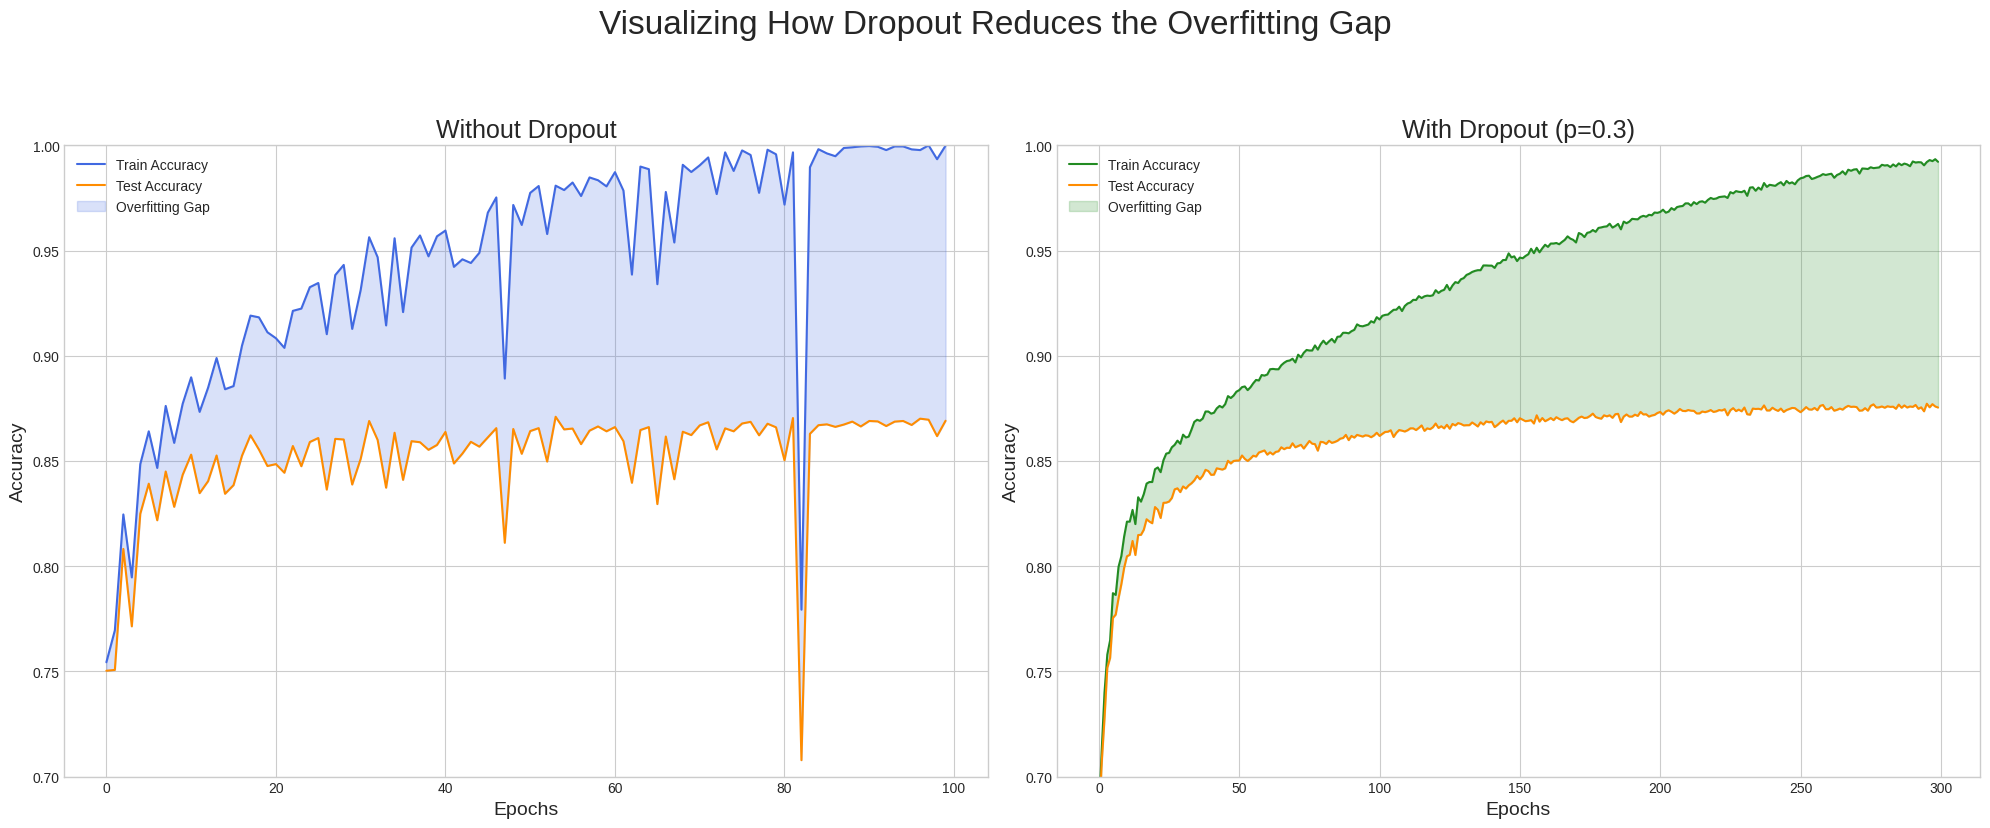

In [ ]:
# --- Use a clean and professional plot style ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# --- Plot 1: Model WITHOUT Dropout ---
ax1.plot(losses['train_acc'], label='Train Accuracy', color='royalblue')
ax1.plot(losses['test_acc'], label='Test Accuracy', color='darkorange')
# Fill the gap between train and test accuracy
ax1.fill_between(range(len(losses['train_acc'])),
                 losses['train_acc'],
                 losses['test_acc'],
                 color='royalblue', alpha=0.2, label='Overfitting Gap')
ax1.set_title('Without Dropout', fontsize=18)
ax1.set_xlabel('Epochs', fontsize=14)
ax1.set_ylabel('Accuracy', fontsize=14)
ax1.legend()
ax1.set_ylim(0.7, 1.0)

# --- Plot 2: Model WITH Dropout ---
ax2.plot(losses_drop['train_acc'], label='Train Accuracy', color='forestgreen')
ax2.plot(losses_drop['test_acc'], label='Test Accuracy', color='darkorange')
# Fill the gap between train and test accuracy
ax2.fill_between(range(len(losses_drop['train_acc'])),
                 losses_drop['train_acc'],
                 losses_drop['test_acc'],
                 color='forestgreen', alpha=0.2, label='Overfitting Gap')
ax2.set_title('With Dropout (p=0.3)', fontsize=18)
ax2.set_xlabel('Epochs', fontsize=14)
ax2.set_ylabel('Accuracy', fontsize=14)
ax2.legend()
ax2.set_ylim(0.7, 1.0)

# --- Add an overall title ---
fig.suptitle('Visualizing How Dropout Reduces the Overfitting Gap', fontsize=24, y=1.03)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

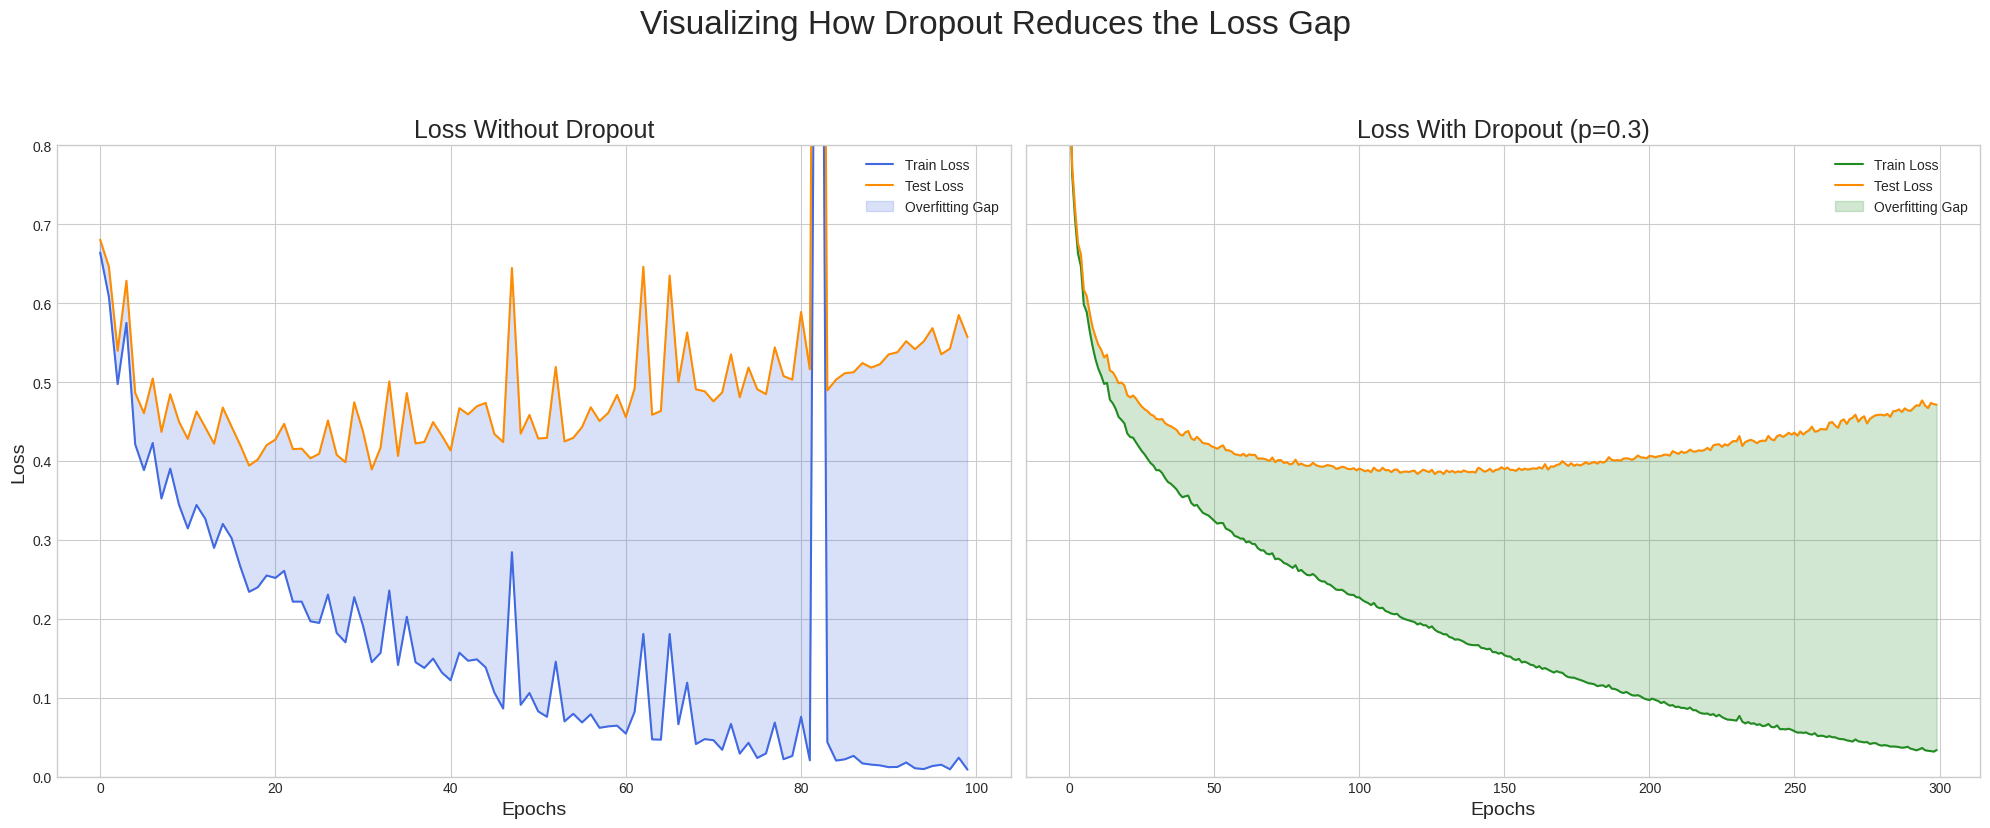

In [ ]:
# --- Use a clean and professional plot style ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), sharey=True) # sharey makes comparison easier

# ==================================
#    Plot 1: Loss WITHOUT Dropout
# ==================================
ax1.plot(losses['train_loss'], label='Train Loss', color='royalblue')
ax1.plot(losses['test_loss'], label='Test Loss', color='darkorange')

# Fill the gap between train and test loss to highlight overfitting
ax1.fill_between(range(len(losses['train_loss'])),
                 losses['train_loss'],
                 losses['test_loss'],
                 color='royalblue', alpha=0.2, label='Overfitting Gap')

ax1.set_title('Loss Without Dropout', fontsize=18)
ax1.set_xlabel('Epochs', fontsize=14)
ax1.set_ylabel('Loss', fontsize=14)
ax1.legend(loc='upper right')
ax1.set_ylim(0, 0.8) # Set a consistent y-axis for direct comparison

# ==================================
#     Plot 2: Loss WITH Dropout
# ==================================
ax2.plot(losses_drop['train_loss'], label='Train Loss', color='forestgreen')
ax2.plot(losses_drop['test_loss'], label='Test Loss', color='darkorange')

# Fill the gap between train and test loss
ax2.fill_between(range(len(losses_drop['train_loss'])),
                 losses_drop['train_loss'],
                 losses_drop['test_loss'],
                 color='forestgreen', alpha=0.2, label='Overfitting Gap')

ax2.set_title('Loss With Dropout (p=0.3)', fontsize=18)
ax2.set_xlabel('Epochs', fontsize=14)
# ax2.set_ylabel('Loss', fontsize=14) # Not needed due to sharey=True
ax2.legend(loc='upper right')

# --- Add an overall title for the entire figure ---
fig.suptitle('Visualizing How Dropout Reduces the Loss Gap', fontsize=24, y=1.03)
plt.tight_layout(rect=[0, 0, 1, 0.97]) # Adjust layout to make space for suptitle
plt.show()

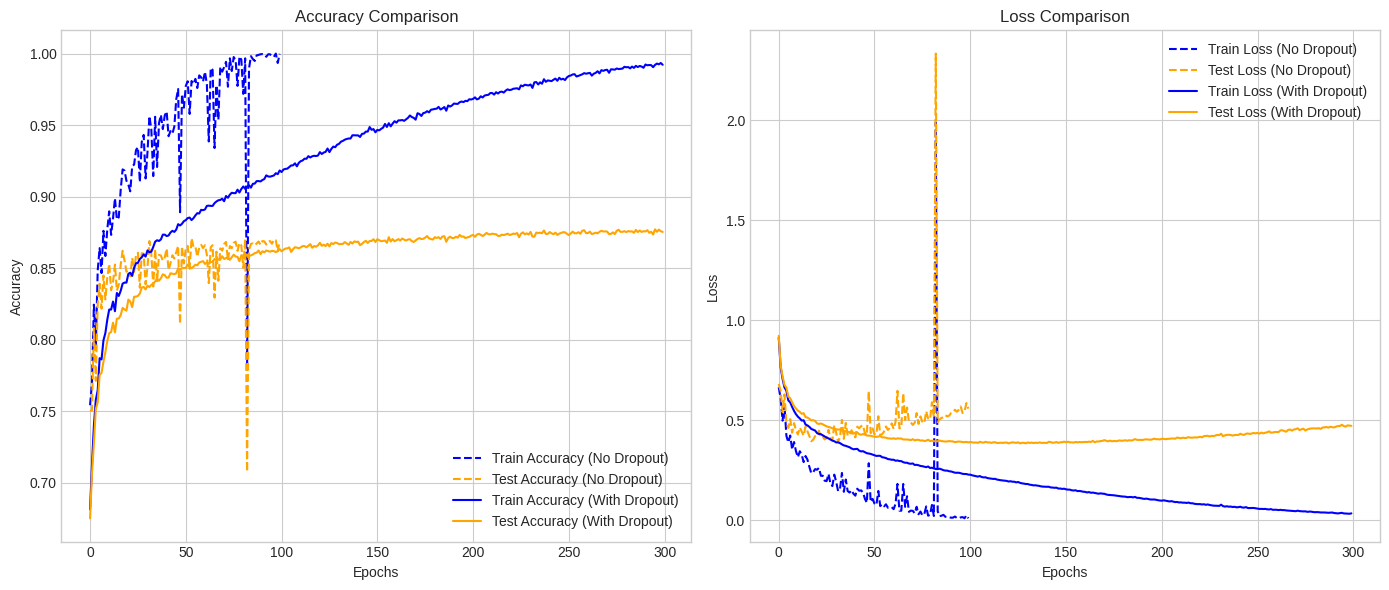

In [ ]:
# --- Plot the results ---
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(losses['train_acc'], label='Train Accuracy (No Dropout)', color='blue', linestyle='--')
plt.plot(losses['test_acc'], label='Test Accuracy (No Dropout)', color='orange', linestyle='--')
plt.plot(losses_drop['train_acc'], label='Train Accuracy (With Dropout)',color='blue' )
plt.plot(losses_drop['test_acc'], label='Test Accuracy (With Dropout)', color='orange')
plt.title('Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(losses['train_loss'], label='Train Loss (No Dropout)', color='blue', linestyle='--')
plt.plot(losses['test_loss'], label='Test Loss (No Dropout)', color='orange', linestyle='--')
plt.plot(losses_drop['train_loss'], label='Train Loss (With Dropout)', color='blue')
plt.plot(losses_drop['test_loss'], label='Test Loss (With Dropout)', color='orange')
plt.title('Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()